# Result Presentation

Use this notebook to reproduce all figures and tables.

In [2]:
from __future__ import print_function, absolute_import, division

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os, json, time, datetime, logging, warnings, itertools
import tqdm, json, sqlite3, ast
import pathos
import rich
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc
import seaborn as sns


In [3]:
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})
sns.set_style({'font.family': 'serif'})

## if errs, disable tex
matplotlib.rc('text', usetex=True)


In [4]:
import src.metric_utils as metric_utils
import src.metrics as metrics
import src.plotter as plotter

In [5]:
DATA_PATH = Path('./exp_data')


## (Optional) Computing Accuracies

Computing the accuracies. Alternatively, can skip this section by using pre-computed results.

### (Optional) Load Data

#### COPA

In [6]:
copa_dev = pd.read_json(DATA_PATH / "copa_dev.json", lines=True, orient='records').set_index('idx')
copa_test = pd.read_csv(DATA_PATH / "copa_test.json")


copa_dev_proc = pd.read_csv(DATA_PATH / "copa_dev_probs.csv" )
copa_dev_proc = metric_utils.proc_data(copa_dev_proc)

copa_test_proc = pd.read_csv(DATA_PATH / "copa_test_probs.csv" )
copa_test_proc = metric_utils.proc_data(copa_test_proc)


## w/o temporality fine-tuning
copa_dev_noft_proc = pd.read_csv(DATA_PATH / "copa_dev_probs_noft.csv" )
copa_dev_noft_proc = metric_utils.proc_data(copa_dev_noft_proc)

copa_test_noft_proc = pd.read_csv(DATA_PATH / "copa_test_probs_noft.csv" )
copa_test_noft_proc = metric_utils.proc_data(copa_test_noft_proc)

#### GLUCOSE

In [7]:
glt_d1 = pd.read_csv(DATA_PATH / "glucose_d1_probs.csv",)
glt_d1 = metric_utils.proc_data(glt_d1)

## w/o temporality fine-tuning
glt_d1_noft = pd.read_csv(DATA_PATH / "glucose_d1_probs_noft.csv",)
glt_d1_noft = metric_utils.proc_data(glt_d1_noft)


### (Optional) Sanity Check

Best zero-shot accuracy on COPA-DEV

In [8]:
metric_utils.test_eps_copa(metrics.delta_bar,copa_dev_proc,copa=copa_dev,
              direct_match=False,
              normalization=True,
              use_cooccur=False, 
              temp_filter=False,
              res_norm=True,
              ord=2,
              pxa_all_norm=False,
              eps=0.006029,
             col_name='best_dl2'
             )

0.7

### (Optional) Grid Search for $\epsilon$ and Design Choices

**NB:** all computations require `pathos` package for multiprocessing

In [9]:
configs = list(itertools.product(
    # D * S * Q
    [  (False, True, True), (False, False, True),
       (False, False, False),(False, True, False), 
       (True, True,True)
    ], 
    # C * E
    [  (False, True), (False, False), (True, True) ],
    # F
    [False, True], # temp_filter F 
))


In [10]:
tasks_ft = [
    ('copa-dev', dict(dat=copa_dev_proc, copa=copa_dev, test_func=metric_utils.test_eps_copa)),
    ('copa-test', dict(test_func=metric_utils.test_eps_copa, dat=copa_test_proc, copa=copa_test)),
    ('glucose-d1', dict(test_func=metric_utils.test_eps_gl, dat=glt_d1,)),
]

tasks_noft = [
    ('copa-dev-noft', dict(dat=copa_dev_noft_proc, copa=copa_dev, test_func=metric_utils.test_eps_copa)),
    ('copa-test-noft', dict(dat=copa_test_noft_proc, copa=copa_test, test_func=metric_utils.test_eps_copa)),
    ('glucose-d1-noft', dict(test_func=metric_utils.test_eps_gl, dat=glt_d1_noft,)),
]

#### w/ fine-tuning

In [13]:
epss=np.hstack([np.linspace(0.00001, 0.1, 700), 
                np.linspace(0.1, 0.2, 400) ,
                np.linspace(0.2, 1, 50) ])


In [16]:
tasks = tasks_noft
res_df = []
for dataset_name, kwargs in tqdm.tqdm(tasks):
    for (dm, nm, pn), (co, rn), tf in configs:
        dt =  metric_utils.get_metrics_todf_mult(epss,
                               direct_match=dm,
                               normalization=nm, 
                               use_cooccur=co,  
                               temp_filter=tf,  
                               res_norm=rn,
                               pxa_all_norm=pn,
                               **kwargs)
        dt[['direct_match', 'normalization', 'use_cooccur', 'res_norm','temp_filter','pxa_norm']] = dm,nm,co,rn,tf,pn
        dt['dataset_name'] = dataset_name
        res_df.append(dt)
        

100%|██████████| 1/1 [00:32<00:00, 32.07s/it]


In [ ]:
ab_results = pd.concat(res_df)
# ab_results = pd.to_csv(DATA_PATH / 'acc_res_full.csv', header=True, index=None)


#### w/o fine-tuning

In [ ]:

epss=np.hstack([np.linspace(0.00001, 0.1, 100), 
                np.linspace(0.1, 0.2, 100) ,
                np.linspace(0.2, 1, 50) ])


In [17]:
tasks = tasks_noft
res_df = []
for dataset_name, kwargs in tqdm.tqdm(tasks):
    for (dm, nm, pn), (co, rn), tf in configs:
        dt =  metric_utils.get_metrics_todf_mult(epss,
                               direct_match=dm,
                               normalization=nm, 
                               use_cooccur=co,  
                               temp_filter=tf,  
                               res_norm=rn,
                               pxa_all_norm=pn,
                               **kwargs)
        dt[['direct_match', 'normalization', 'use_cooccur', 'res_norm','temp_filter','pxa_norm']] = dm,nm,co,rn,tf,pn
        dt['dataset_name'] = dataset_name
        res_df.append(dt)

 33%|███▎      | 1/3 [01:06<02:13, 66.69s/it]

In [ ]:
ab_noft_results = pd.concat(res_df)
# ab_noft_results = pd.read_csv(DATA_PATH / 'acc_noft_res_full.csv', header=True, index=None)


### (Optional) Ablation on Covariate Set Size $N$

In [18]:
epss = [0.001, 0.003, 0.005, 0.006,0.008,  0.01, 0.02, 0.03, 0.04, 0.05, 0.06] 

In [19]:
tasks = tasks_ft
res_df = []
for dataset_name, kwargs in tqdm.tqdm(tasks):
    for n_smp in [5, 10, 20, 30, 40,50, 60, 70, 80, 90, 100]:
        dt =  metric_utils.metric_utils.get_metrics_todf_N_mult(epss,
                                    n_smp=n_smp,
                                    n_rep=50,
                               direct_match=False,
                               normalization=True, 
                               use_cooccur=False,  
                               temp_filter=False,  
                                **kwargs
                               )
        dt[['direct_match', 'normalization', 'use_cooccur', 'temp_filter']] = False,True,False,False
        dt['N'] = n_smp
        dt['dataset_name'] = dataset_name
        res_df.append(dt)

        

In [ ]:
acc_N_results = pd.concat(res)
# acc_N_results.to_csv('acc_N_res.csv', header=True, index=None)

## Figures

Using pre-computed result.

In [11]:
# w/ temporality fine-tuning
ab_results = pd.read_csv(DATA_PATH / 'acc_res_full.csv')

# w/o temporality fine-tuning
ab_noft_results = pd.read_csv(DATA_PATH / 'acc_noft_res_full.csv')

# ablations on N
acc_N_results = pd.read_csv(DATA_PATH / 'acc_N_res.csv', )

### Figure 3

We only plot a subset of $500$ possible $\epsilon$, hence the exact figure may slightly differ.

In [12]:
plt_epss = np.sort(ab_results.eps.unique())[1:]
plt_epss = plt_epss[plt_epss<=0.5]
plt_epss = np.sort(np.random.choice(plt_epss, 500))
sns.set_palette('deep',6)

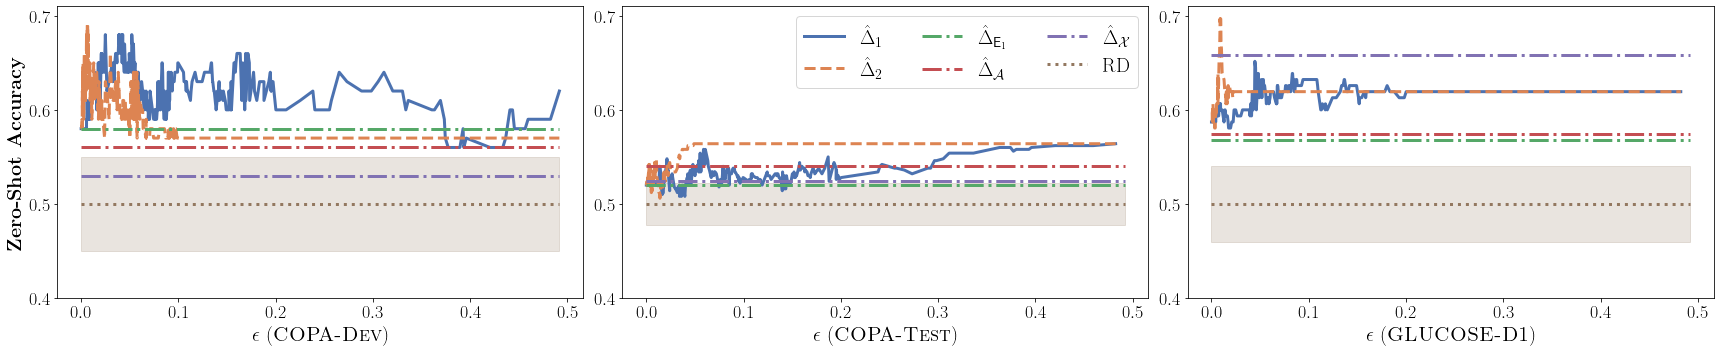

In [13]:
plt.figure(figsize=(24,5))

plt.subplot(1,3,1)
plotter.viz_acc_eps(ab_results, plt,'copa-dev', ylim=[0.43, 0.71],
            y_title=r'\textbf{Zero-Shot Accuracy}', std=0.05, epss=plt_epss, x_label=r" (\textsc{COPA-Dev})", legend=None)

plt.subplot(1,3,2)
plotter.viz_acc_eps(ab_results, plt,'copa-test',ylim=[0.43, 0.71],
            std=np.sqrt(500)/1000,epss=plt_epss, x_label=r" (\textsc{COPA-Test})", 
            legend=1)

plt.subplot(1,3,3)
plotter.viz_acc_eps(ab_results, plt,'glucose-d1', ylim=[0.43, 0.71],
            std=np.sqrt(156)/312,epss=plt_epss, x_label=r" (\textsc{GLUCOSE-D1})", legend=None)

plt.tight_layout()
# plt.savefig('acc_eps_all_y.pdf', bbox_inches='tight')



##### The Full Picture

The balanced scores do not convege to the unadjusted score as $\epsilon \to 1$ in COPA-Test due to normalizations used.

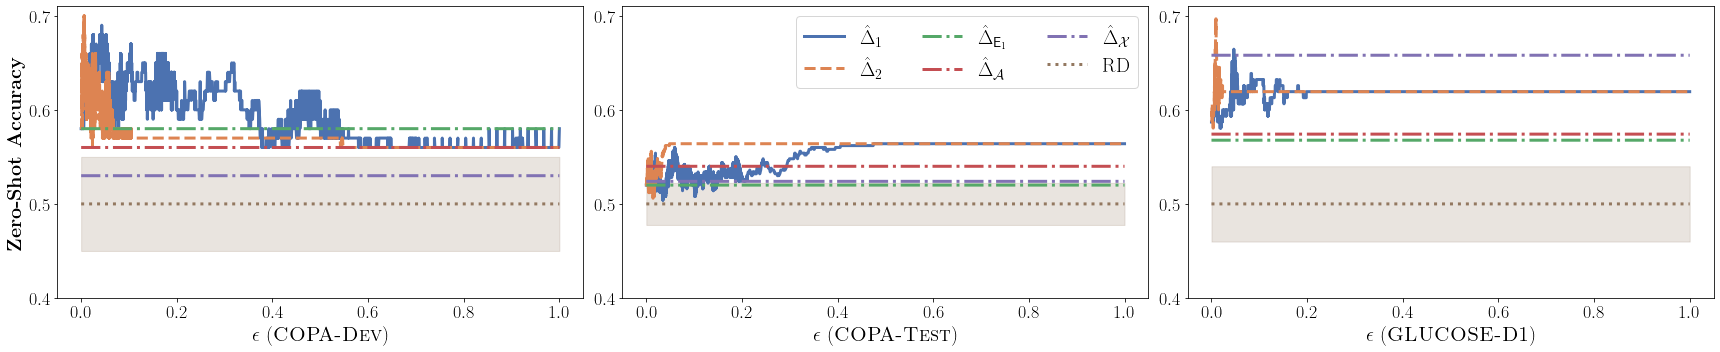

In [34]:
sns.set_palette('deep',6)
plt.figure(figsize=(24,5))

plt.subplot(1,3,1)
plotter.viz_acc_eps(ab_results, plt,'copa-dev', ylim=[0.43, 0.71],
            y_title=r'\textbf{Zero-Shot Accuracy}', std=0.05, epss=None, x_label=r" (\textsc{COPA-Dev})", legend=None)

plt.subplot(1,3,2)
plotter.viz_acc_eps(ab_results, plt,'copa-test',ylim=[0.43, 0.71],
            std=np.sqrt(500)/1000,epss=None, x_label=r" (\textsc{COPA-Test})", 
            legend=1)

plt.subplot(1,3,3)
plotter.viz_acc_eps(ab_results, plt,'glucose-d1', ylim=[0.43, 0.71],
            std=np.sqrt(156)/312,epss=None, x_label=r" (\textsc{GLUCOSE-D1})", legend=None)

plt.tight_layout()
# plt.savefig('acc_eps_all_y.pdf', bbox_inches='tight')



### Figure 4

In [14]:
# The results we reported in the paper only enables Score Normalization (S)
acc_N_df = acc_N_results[~acc_N_results.use_cooccur]

In [15]:
sns.set_palette('flare',len(acc_N_df.N.unique()))

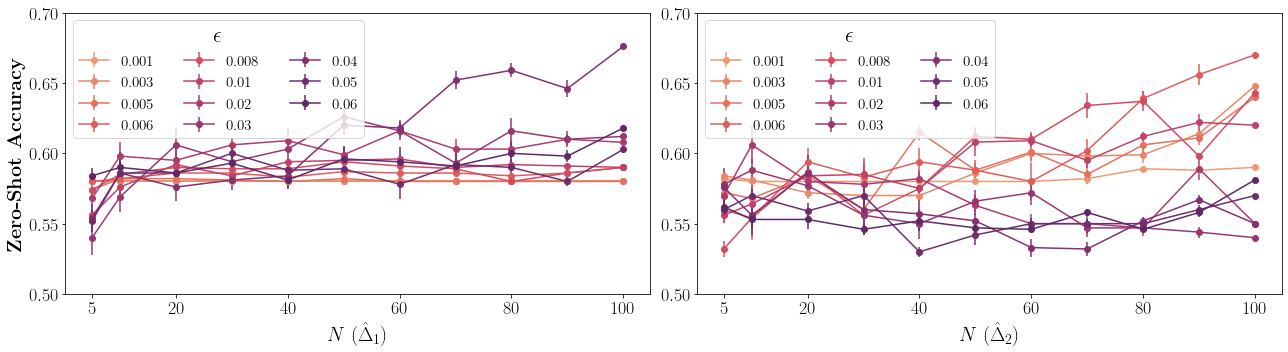

In [16]:
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plotter.viz_acc_n(acc_N_df, plt, 'copa-dev',
          score='score_dl1', x_label=r" ($\hat{\Delta}_1$)",
          y_title=r"\textbf{Zero-Shot Accuracy}",
         legend=2)

plt.subplot(1,2,2)
plotter.viz_acc_n(acc_N_df, plt, 'copa-dev', 
          score='score_dl2', x_label=r" ($\hat{\Delta}_2$)",
          legend=2)

plt.tight_layout()
# plt.savefig('acc_N_copadev.pdf')

## Tables

### Table 1: Best zero-shot results

In [17]:
def print_tbl_row_best(dt, dataset_suffix=''):
    for ds in ['copa-dev', 'copa-test', 'glucose-d1']:
        ds_max = (dt.query(f"dataset_name=='{ds}{dataset_suffix}'")
              .groupby(['score'])['acc']
              .max())[['score_dl1', 'score_dl2', 'score_de1', 'score_da', 'score_dx']]
        print(ds, "&".join([rf" ${v:.4f}$ " for v in ds_max.values]) )

In [18]:
## w temporality fine-tuning
print_tbl_row_best(ab_results)

copa-dev  $0.6900$ & $0.7000$ & $0.5800$ & $0.5600$ & $0.5300$ 
copa-test  $0.5640$ & $0.5640$ & $0.5200$ & $0.5400$ & $0.5240$ 
glucose-d1  $0.6645$ & $0.6968$ & $0.5677$ & $0.5742$ & $0.6581$ 


In [19]:
## w/o temporality fine-tuning
print_tbl_row_best(ab_noft_results, '-noft')

copa-dev  $0.6200$ & $0.6300$ & $0.5300$ & $0.4800$ & $0.5300$ 
copa-test  $0.5800$ & $0.5740$ & $0.4540$ & $0.4600$ & $0.4860$ 
glucose-d1  $0.6065$ & $0.6194$ & $0.5548$ & $0.4387$ & $0.3742$ 


### Table 2: Single-component ablations on normalizations

Note: $\LaTeX$ commands `\abpoor` and `\abgood` highlight their argument in different colors.

In [20]:
for i in range(6):
    all_best = ab_results.query("score.str.contains('dl')").groupby(['dataset_name','score'])['acc'].max()
    ABL = ["direct_match", "temp_filter", "normalization", "pxa_norm", "use_cooccur", "res_norm"]
    dt = ab_results.query(f"{ABL[i]} == False")
    dt_max = dt.query("score.str.contains('dl')").groupby(['dataset_name','score'])['acc'].max()
    dec = (all_best.values-dt_max.values)/all_best.values
    print(rf"Best w/o \textsf{{{'DFSQCE'[i]}}} &", "&".join([rf" \abpoor{{-${v:.2f}\%$}} " if v>0 else ' - ' for v in dec]), r"\\")



Best w/o \textsf{D} &  - & - & - & - & - & -  \\
Best w/o \textsf{F} &  - & - & - & - & - & -  \\
Best w/o \textsf{S} &  \abpoor{-$0.01\%$} & \abpoor{-$0.06\%$} & - & - & \abpoor{-$0.08\%$} & \abpoor{-$0.11\%$}  \\
Best w/o \textsf{Q} &  \abpoor{-$0.01\%$} & - & - & - & \abpoor{-$0.03\%$} & -  \\
Best w/o \textsf{C} &  - & - & \abpoor{-$0.01\%$} & \abpoor{-$0.01\%$} & \abpoor{-$0.09\%$} & \abpoor{-$0.13\%$}  \\
Best w/o \textsf{E} &  \abpoor{-$0.01\%$} & \abpoor{-$0.01\%$} & - & - & \abpoor{-$0.03\%$} & -  \\


### Table A.1: Best $\epsilon$ when $\epsilon < 0.1$

In [21]:
dt = ab_results.query('eps<0.1')
dt.loc[dt.groupby(['dataset_name','score']).acc.idxmax()].query("score.str.contains('dl')")[['eps', 'acc']]

,eps,acc
321331,0.043067,0.690000
289494,0.006029,0.700000
431988,0.059232,0.560000
13639,0.048837,0.564000
505596,0.046643,0.664516
15992,0.009374,0.696774


### Table A.2: Full Ablation Studies

In [22]:
full_configs = metric_utils.gen_full_ablation_config()

In [23]:
## table param
print("".join([r"p{1cm}"]*len(full_configs)))

## title row
print("&".join([metric_utils.gen_config_str(cfg) for cfg in full_configs]))

p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}
 $\emptyset$ & +\textbf{D} & +\textbf{F} & +\textbf{S} & +\textbf{Q} & +\textbf{C} & +\textbf{E} & +\textbf{D}\textbf{F} & +\textbf{D}\textbf{C} & +\textbf{D}\textbf{E} & +\textbf{F}\textbf{S} & +\textbf{F}\textbf{Q} & +\textbf{F}\textbf{C} & +\textbf{F}\textbf{E} & +\textbf{S}\textbf{Q} & +\textbf{S}\textbf{C} & +\textbf{S}\textbf{E} & +\textbf{Q}\textbf{C} & +\textbf{Q}\textbf{E} & +\textbf{D}\textbf{F}\textbf{C} & +\textbf{D}\textbf{F}\textbf{E} & +\textbf{F}\textbf{S}\textbf{Q} & +\textbf{F}\textbf{S}\textbf{Q}\textbf{C} & +\textbf{F}\textbf{S}\textbf{Q}\textbf{E} & +\textbf{F}\textbf{Q}\textbf{C} & +\textbf{F}\textbf{Q}\textbf{E} & +\textbf{S}\textbf{Q}\textbf{C} & +\textbf{S}\textbf{Q}\textbf{E} & +\textbf{F}\textbf{S}\textbf{Q}\textbf{C} & +\textbf{F}\textbf{S}\textbf{Q}\textbf{E} 


In [24]:
metric_utils.print_full_abl_table(ab_results, configs=full_configs)

copa-dev/score_dl1:  $0.690$ & $0.620$ & $0.670$ & $0.660$ & $0.670$ & $0.680$ & $0.650$ & $0.650$ & $0.680$ & $0.660$ & $0.650$ & $0.680$ & $0.680$ & $0.650$ & $0.650$ & $0.680$ & $0.670$ & \abpoor{$0.620$} & $0.680$ & $0.640$ & $0.660$ & $0.650$ & $0.680$ & $0.670$ & $0.660$ & \abgood{$0.690$} & $0.640$ & $0.660$ & $0.660$ & \abgood{$0.690$} & $0.660$ & \abgood{$0.690$} 

copa-dev/score_dl2:  $0.700$ & $0.630$ & \abpoor{$0.630$} & $0.650$ & \abpoor{$0.630$} & $0.690$ & \abpoor{$0.630$} & $0.660$ & $0.640$ & $0.650$ & $0.650$ & $0.680$ & $0.690$ & \abpoor{$0.630$} & $0.660$ & $0.640$ & $0.670$ & \abpoor{$0.630$} & \abgood{$0.700$} & $0.650$ & $0.660$ & $0.650$ & $0.680$ & $0.670$ & $0.640$ & \abgood{$0.700$} & $0.650$ & $0.660$ & $0.640$ & \abgood{$0.700$} & $0.640$ & \abgood{$0.700$} 

copa-test/score_dl1:  $0.564$ & $0.528$ & $0.542$ & $0.548$ & $0.542$ & $0.540$ & $0.548$ & \abgood{$0.564$} & $0.554$ & $0.548$ & \abgood{$0.564$} & $0.554$ & $0.540$ & $0.548$ & \abgood{$0.564$} & $0

In [25]:
metric_utils.print_full_abl_table(ab_noft_results, configs=full_configs)

copa-dev-noft/score_dl1:  $0.620$ & $0.550$ & $0.590$ & \abpoor{$0.550$} & $0.590$ & $0.580$ & $0.580$ & $0.570$ & \abgood{$0.620$} & \abpoor{$0.550$} & $0.560$ & $0.610$ & $0.580$ & $0.580$ & $0.570$ & \abgood{$0.620$} & $0.580$ & $0.560$ & \abgood{$0.620$} & $0.560$ & \abgood{$0.620$} & $0.560$ & $0.610$ & $0.580$ & $0.560$ & $0.610$ & $0.560$ & \abgood{$0.620$} & $0.560$ & $0.610$ & $0.560$ & $0.610$ 

copa-dev-noft/score_dl2:  $0.630$ & $0.530$ & $0.610$ & \abpoor{$0.530$} & $0.610$ & $0.600$ & $0.580$ & $0.600$ & \abgood{$0.630$} & \abpoor{$0.530$} & $0.550$ & $0.600$ & $0.600$ & $0.580$ & $0.600$ & \abgood{$0.630$} & $0.580$ & $0.580$ & $0.610$ & $0.580$ & $0.620$ & $0.550$ & $0.600$ & $0.580$ & $0.560$ & $0.610$ & $0.580$ & $0.620$ & $0.560$ & $0.610$ & $0.560$ & $0.610$ 

copa-test-noft/score_dl1:  $0.580$ & $0.484$ & $0.494$ & $0.486$ & $0.494$ & $0.522$ & $0.498$ & \abpoor{$0.484$} & $0.574$ & $0.486$ & $0.496$ & $0.574$ & $0.522$ & $0.498$ & \abpoor{$0.484$} & $0.574$ & $0.5

### Full Examples

In [26]:
metric_utils.test_eps_copa(metrics.delta_bar,copa_dev_proc,copa=copa_dev,
              direct_match=False,
              normalization=True,
              use_cooccur=False, 
              temp_filter=False,
              res_norm=True,
              ord=2,
              pxa_all_norm=False,
              eps=0.006029,
              col_name='best_dl2'
             )

0.7

In [27]:
metric_utils.test_eps_copa(metrics.delta_bar,copa_dev_proc,copa=copa_dev,
              direct_match=False,
              normalization=True,
              use_cooccur=False, 
              temp_filter=False,
              eps=0.039473,
              col_name='best_dl1'
             )

0.68

In [28]:
metric_utils.test_eps_copa(metrics.delta_pxd,copa_dev_proc,copa=copa_dev,
              eps=-1,
             col_name='de1')
metric_utils.test_eps_copa(metrics.delta_palldy,copa_dev_proc,copa=copa_dev,
              eps=-1,
             col_name='da')
metric_utils.test_eps_copa(metrics.delta_pxd,copa_dev_proc,copa=copa_dev,
              eps=-1,
             col_name='dx')

0.53

In [29]:
def copa_query_best(copa_proc, idx):
    return (copa_proc.query(f"index=={idx}")[['best_dl1', 'best_dl2', 'de1', 'da', 'dx']]
            .apply(lambda s : "&".join([rf" ${v:.3f}$ " for v in s.values]),axis=1)
            .values)

In [30]:
copa_query_best(copa_dev_proc, 72)

array([' $-0.002$ & $-0.002$ & $0.106$ & $0.002$ & $0.106$ ',
       ' $-0.001$ & $-0.001$ & $0.086$ & $-0.012$ & $0.086$ '],
      dtype=object)

In [31]:
copa_query_best(copa_dev_proc, 63)

array([' $-0.010$ & $-0.010$ & $0.068$ & $0.036$ & $0.068$ ',
       ' $0.002$ & $0.001$ & $0.098$ & $0.035$ & $0.098$ '], dtype=object)

In [32]:
copa_query_best(copa_dev_proc, 79)

array([' $0.056$ & $-0.001$ & $0.109$ & $0.096$ & $0.109$ ',
       ' $0.005$ & $-0.010$ & $0.279$ & $0.118$ & $0.279$ '], dtype=object)